In [1]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

Sample Texts:

'Sex male Age 8 years 0 months Ethnicity European obsolete Sparse  thin eyebrow Sparse eyelashes Cutaneous photosensitivity Poikiloderma Sparse scalp hair Lower-limb joint contracture Lower limb muscle weakness Sparse hair Palmoplantar erythema Abnormality on pulmonary function testing Sparse eyebrow'


'Sex female Age 1 years 8 months Ethnicity European Visual impairment Delayed speech  language development Hypotonia Global developmental delay Delayed gross motor development Intellectual disability severe Abnormality of the digestive system'

'Sex male Age 3 years 6 months Ethnicity European Long palpebral fissure Growth delay Decreased body weight Eversion of lateral third of lower eyelids Feeding difficulties'

In [2]:
#528 total disease labels in GestaltMML v1.0.9. DO NOT MODIFY "528"
num_list = [int(i) for i in range(528)]
label2id = dict(zip(num_list,num_list))
id2label = dict(zip(num_list,num_list))
len(label2id)

528

Sample input texts: "Sex male Age 3 years 6 months Ethnicity European Long palpebral fissure Growth delay Decreased body weight Eversion of lateral third of lower eyelids Feeding difficulties"

In [7]:
#If you don't care about the accuracy or do not know the true label, then "label" does not matter. You can use any number from 0 to 527
columns = ['image_id', 'filename', 'texts', 'label']
data = [(461, '461_aligned.jpg','Sex male Age 3 years 6 months Ethnicity European Long palpebral fissure Growth delay Decreased body weight Eversion of lateral third of lower eyelids Feeding difficulties',269),
        (477, '477_aligned.jpg','Sex male Age 8 years 0 months Ethnicity European obsolete Sparse thin eyebrow Sparse eyelashes Cutaneous photosensitivity Poikiloderma Sparse scalp hair Lower-limb joint contracture Lower limb muscle weakness Sparse hair Palmoplantar erythema Abnormality on pulmonary function testing Sparse eyebrow',269),
        (479, '479_aligned.jpg','Sex female Age 1 years 8 months Ethnicity European Visual impairment Delayed speech language development Hypotonia Global developmental delay Delayed gross motor development Intellectual disability severe Abnormality of the digestive system',269)]
total_test = pd.DataFrame(data, columns=columns)
total_test

,image_id,filename,texts,label
0,461,461_aligned.jpg,Sex male Age 3 years 6 months Ethnicity Europe...,269
1,477,477_aligned.jpg,Sex male Age 8 years 0 months Ethnicity Europe...,269
2,479,479_aligned.jpg,Sex female Age 1 years 8 months Ethnicity Euro...,269


In [8]:
test_questions = []
for i in range(len(total_test)):
    temp_dic = {'image_id':total_test.loc[i,'image_id'],'question':total_test.loc[i,'texts']}
    test_questions.append(temp_dic)

test_questions[0]

{'image_id': 461,
 'question': 'Sex male Age 3 years 6 months Ethnicity European Long palpebral fissure Growth delay Decreased body weight Eversion of lateral third of lower eyelids Feeding difficulties'}

In [9]:
test_annotations = []
for i in range(len(total_test)):
    temp_dic = {'labels':[label2id[total_test.loc[i,'label']]],'scores':[1]}
    test_annotations.append(temp_dic)

test_annotations[0]

{'labels': [269], 'scores': [1]}

In [12]:
#replace root by your own file path
root = '/content/drive/MyDrive/GestaltMML/test_images'
filename_to_id = {root + "/" + total_test.loc[i,'filename']: total_test.loc[i,'image_id'] for i in range(len(total_test))}
id_to_filename = {v:k for k,v in filename_to_id.items()}
filename_to_id

{'/content/drive/MyDrive/GestaltMML/test_images/461_aligned.jpg': 461,
 '/content/drive/MyDrive/GestaltMML/test_images/477_aligned.jpg': 477,
 '/content/drive/MyDrive/GestaltMML/test_images/479_aligned.jpg': 479}

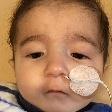

In [13]:
#Sample Image
from PIL import Image
path = id_to_filename[test_questions[0]['image_id']]
image = Image.open(path)
image

In [14]:
from transformers import ViltProcessor
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [15]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, questions, annotations, processor):
        self.questions = questions
        self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image + text - training pairs
        annotation = self.annotations[idx]
        questions = self.questions[idx]
        image = Image.open(id_to_filename[questions['image_id']])
        text = questions['question']
        #send text and image through processor
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        # add labels: true disease & scores: confidence
        labels = annotation['labels']
        scores = annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        # https://github.com/jnhwkim/ban-vqa/blob/master/train.py#L19
        # targets = [0] * number of disease labels
        targets = torch.zeros(len(id2label))
        for label, score in zip(labels, scores):
              targets[label] = score
        # one-hot encoding in our case
        encoding["labels"] = targets

        return encoding

In [ ]:
from transformers import ViltForQuestionAnswering
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 num_labels=len(id2label),
                                                 id2label=id2label,
                                                 label2id=label2id)
#model= nn.DataParallel(model)
model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.weight', 'classifier.1.weight', 'classifier.1.bias', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): ViltForQuestionAnswering(
    (vilt): ViltModel(
      (embeddings): ViltEmbeddings(
        (text_embeddings): TextEmbeddings(
          (word_embeddings): Embedding(30522, 768)
          (position_embeddings): Embedding(40, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (patch_embeddings): ViltPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
        )
        (token_type_embeddings): Embedding(2, 768)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViltEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViltLayer(
            (attention): ViltAttention(
              (attention): ViltSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out

## Testing

In [18]:
from transformers import ViltForQuestionAnswering
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 num_labels=len(id2label),
                                                 id2label=id2label,
                                                 label2id=label2id)
#load the model weights GestaltMML_model.pt. Email dawu@sas.upenn.edu/jeremywu12345@gmail.com for model weights if you have access to GMDB.
PATH = '/content/drive/MyDrive/GestaltMML/GestaltMML_model.pt'
#If you have GPU device, remove "map_location=torch.device('cpu')" below. If you only use CPU, keep as below.
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [19]:
test_dataset = VQADataset(questions = test_questions,
                     annotations = test_annotations,
                     processor=processor)

In [20]:
import json
#Disease Dictionary: Label ID -> real diesease name
with open('/content/drive/MyDrive/GestaltMML/disease_dict.json') as json_file:
    disease_dict = json.load(json_file)
disease_dict[str(1)]

'WILLIAMS-BEUREN SYNDROME; WBS'

In [30]:
#Top-1 most likely diseases predicted by GestaltMML
res = {}
for i in range(len(test_dataset)):
    example = test_dataset[i]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    res[total_test.loc[i,'image_id']] = disease_dict[str(id2label[predicted_class])]
res

{461: 'Hypoplastic left heart syndrome',
 477: 'POIKILODERMA, HEREDITARY FIBROSING, WITH TENDON CONTRACTURES, MYOPATHY, AND PULMONARY FIBROSIS; POIKTMP',
 479: 'MENTAL RETARDATION, AUTOSOMAL DOMINANT 54; MRD54'}

In [31]:
#Top-10 most likely diseases for each image_id
res = {}
for i in range(len(test_dataset)):
  example = test_dataset[i]
  example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
  outputs = model(**example)
  logits = outputs.logits
  #Replace 10 by other number N>1 to test Top-N most likely diseases
  predicted_class = torch.topk(logits,10).indices.flatten().tolist()
  disease_list = [disease_dict[str(id2label[i])] for i in predicted_class]
  res[total_test.loc[i,'image_id']] = disease_list
res_df = pd.DataFrame(res)
res_df

,461,477,479
0,Hypoplastic left heart syndrome,"POIKILODERMA, HEREDITARY FIBROSING, WITH TENDO...","MENTAL RETARDATION, AUTOSOMAL DOMINANT 54; MRD54"
1,DEVELOPMENTAL AND EPILEPTIC ENCEPHALOPATHY 83;...,Rothmund-Thomson syndrome,"INTELLECTUAL DEVELOPMENTAL DISORDER, AUTOSOMAL..."
2,MANDIBULOFACIAL DYSOSTOSIS WITH ALOPECIA; MFDA,Blepharocheilodontic syndrome,SMITH-MAGENIS SYNDROME; SMS
3,LIG4 SYNDROME,"Microcephaly, growth restriction and increased...",PHELAN-MCDERMID SYNDROME; PHMDS
4,"SHORT STATURE, BRACHYDACTYLY, IMPAIRED INTELLE...",LIG4 SYNDROME,PITT-HOPKINS SYNDROME; PTHS
5,"NEUROFIBROMATOSIS, TYPE I; NF1",Focal facial dermal dysplasia,HAO-FOUNTAIN SYNDROME; HAFOUS
6,BOSMA ARHINIA MICROPHTHALMIA SYNDROME; BAMS,BRANCHIOOCULOFACIAL SYNDROME; BOFS,"INTELLECTUAL DEVELOPMENTAL DISORDER, X-LINKED ..."
7,"INTELLECTUAL DEVELOPMENTAL DISORDER, X-LINKED ...",Hutchinson-Gilford progeria,SCHAAF-YANG SYNDROME; SHFYNG
8,"MICROCEPHALY, GROWTH DEFICIENCY, SEIZURES, AND...",CDH8,Long QT syndrome
9,RADIO-TARTAGLIA SYNDROME; RATARS,FONTAINE PROGEROID SYNDROME; FPS,BOSCH-BOONSTRA-SCHAAF OPTIC ATROPHY SYNDROME; ...
